# MAIN QUEST 02

## 데이터 다운로드

In [1]:
import datasets
from datasets import load_dataset

dataset = load_dataset('nateraw/pascal-voc-2012', split='train')

Using custom data configuration nateraw___pascal-voc-2012-c68607404d4811ac
Reusing dataset parquet (/aiffel/.cache/huggingface/datasets/parquet/nateraw___pascal-voc-2012-c68607404d4811ac/0.0.0/9296ce43568b20d72ff8ff8ecbc821a16b68e9b8b7058805ef11f06e035f911a)


In [2]:
dataset

Dataset({
    features: ['image', 'mask'],
    num_rows: 2913
})

In [3]:
images_data = dataset['image'][:1500]
masks_data = dataset['mask'][:1500]

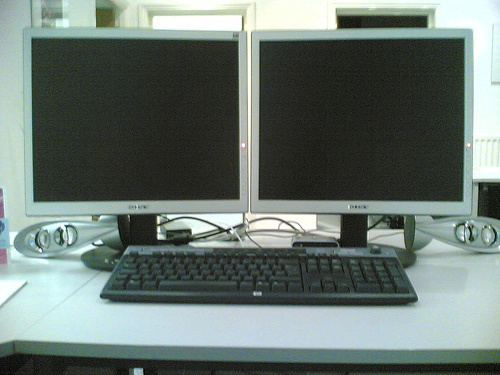

In [4]:
# images 확인
from PIL import Image
import io

byte_stream = io.BytesIO(dataset['image'][4]['bytes'])
image = Image.open(byte_stream)
image.show()


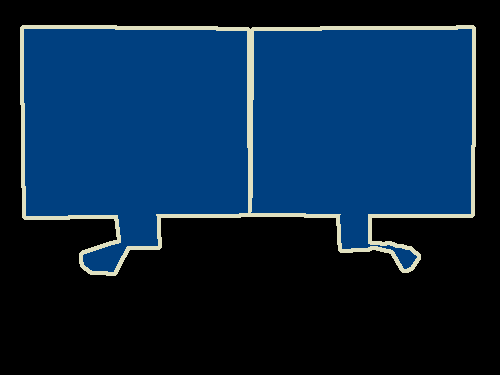

In [5]:
# masks
byte_stream = io.BytesIO(dataset['mask'][4]['bytes'])
image = Image.open(byte_stream)
image.show()


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

input_size = (128, 128)

def change_byte_to_np(images_data, batch_size=32):
    images_np = []
    num_images = len(images_data)
    num_batches = (num_images + batch_size - 1)//batch_size
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1)*batch_size, num_images)
        
        batch_images_data = images_data[start_idx:end_idx]
        batch_images_np = []
        
        for image_data_dict in batch_images_data:
            image_data = image_data_dict['bytes']
            image_pil = Image.open(io.BytesIO(image_data))
            image_pil_resized = image_pil.resize(input_size)  # 입력 크기 조절
            image_np = np.array(image_pil_resized) / 255.0  # [0, 1] 범위로 조절
            batch_images_np.append(image_np)
        
        batch_images_np = np.array(batch_images_np)
        images_np.extend(batch_images_np)
    
    images_np = np.stack(images_np, axis=0)
    return images_np


In [7]:
images_np = change_byte_to_np(images_data)
mask_np = change_byte_to_np(masks_data)


In [8]:
from sklearn.model_selection import train_test_split

# 데이터 분할
images_train, images_temp, masks_train, masks_temp = train_test_split(images_np, mask_np, test_size=0.4, random_state=42)
images_val, images_test, masks_val, masks_test = train_test_split(images_temp, masks_temp, test_size=0.5, random_state=42)

## 이미지 데이터 전처리
사이즈조정, 정규화

In [9]:
import tensorflow as tf
def normalization(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

## 모델 설계

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

def unet(input_shape, num_classes):
    inputs = Input(input_shape)
    
    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # Bottom
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Expansive Path
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    # Output
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [11]:
# 모델 구성
input_shape = (128, 128, 3)  # 입력 이미지 크기와 채널 수
model = unet(input_shape=input_shape, num_classes=3)


In [12]:

# 모델 요약 출력
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

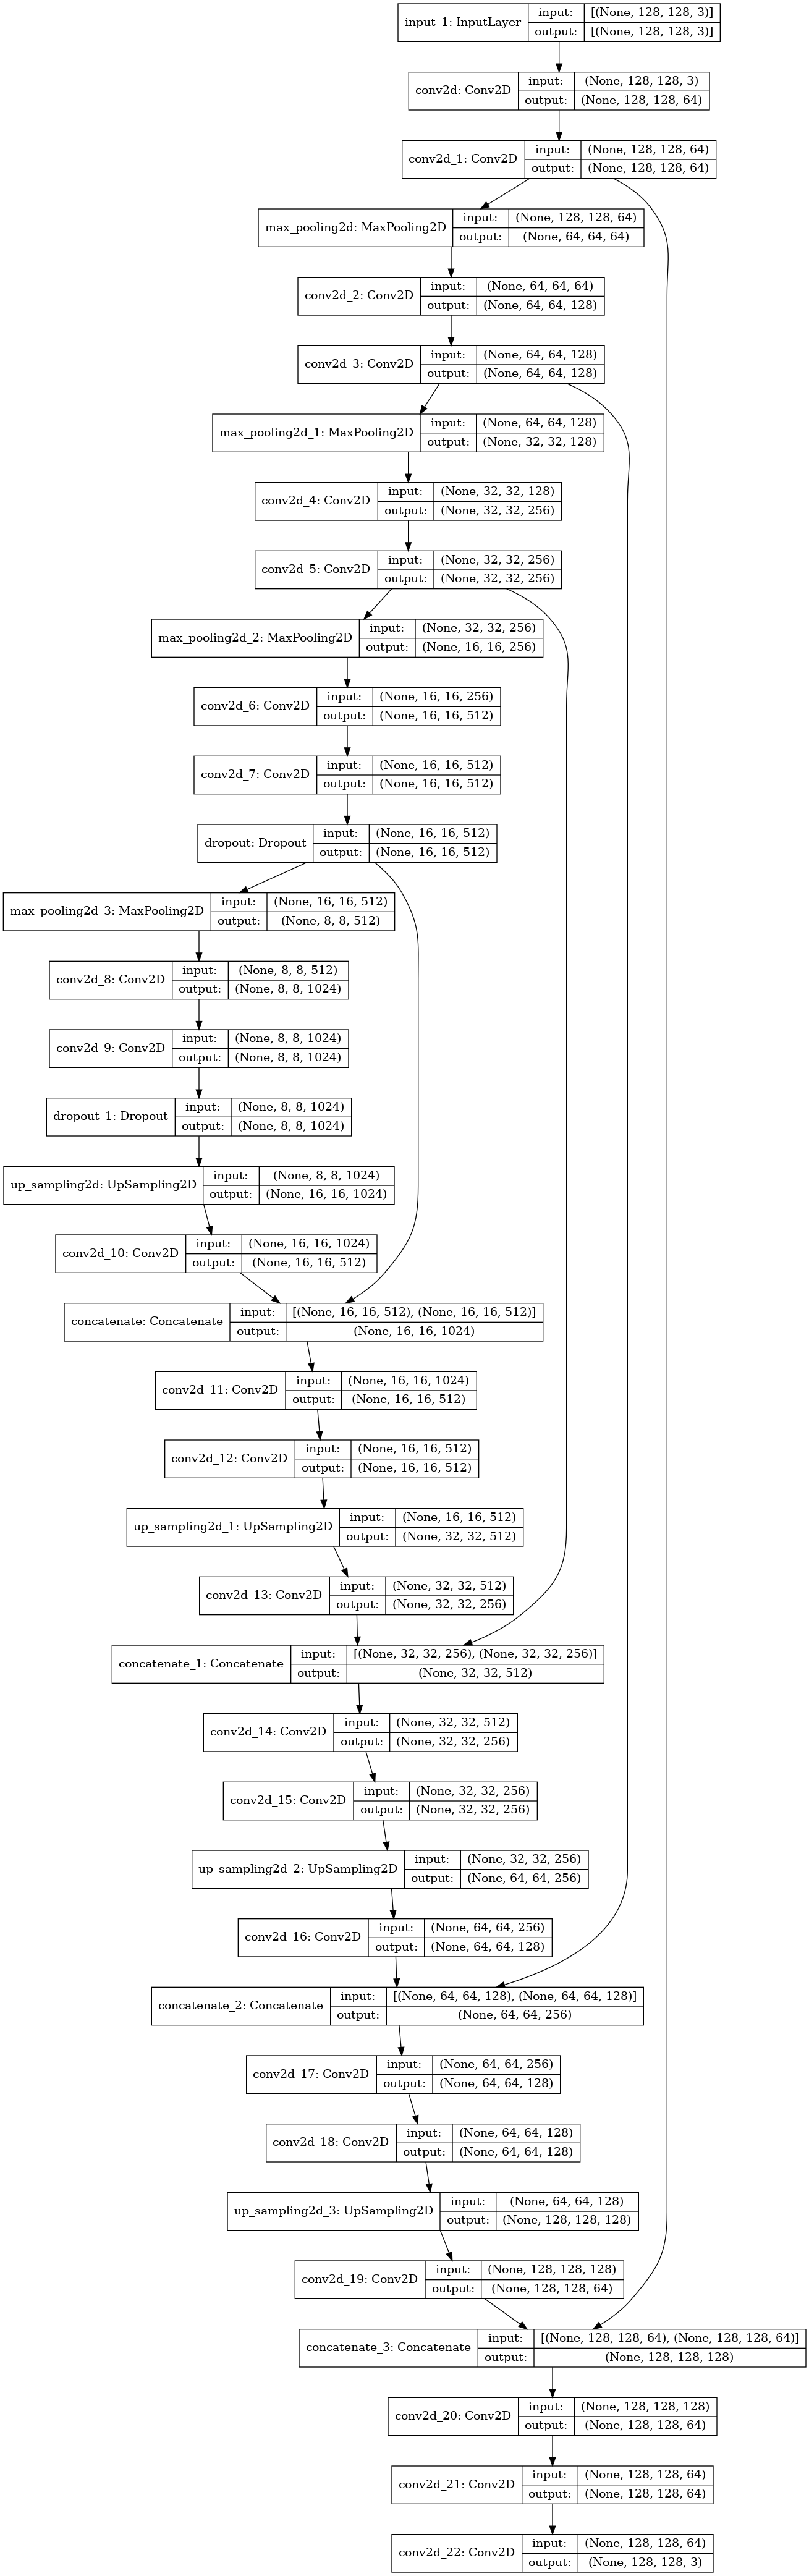

In [13]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

In [14]:
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True),
             #keras.callbacks.TensorBoard(log_dir='./tb'),
             keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
            ]

batch_size = 32

history = model.fit(images_train, masks_train,
                    epochs=200,
                    batch_size= batch_size,
                    validation_data=(images_val, masks_val),
                    callbacks=callbacks)

Epoch 1/200
29/29 [==============================] - 79s 780ms/step - loss: 3260.5425 - accuracy: 0.6724 - val_loss: 0.4378 - val_accuracy: 0.2392
Epoch 2/200
29/29 [==============================] - 15s 516ms/step - loss: 0.3999 - accuracy: 0.7249 - val_loss: 0.4203 - val_accuracy: 0.8605
Epoch 3/200
29/29 [==============================] - 15s 510ms/step - loss: 0.4040 - accuracy: 0.7986 - val_loss: 0.4116 - val_accuracy: 0.8605
Epoch 4/200
29/29 [==============================] - 15s 508ms/step - loss: 0.3901 - accuracy: 0.7496 - val_loss: 0.4292 - val_accuracy: 0.7970
Epoch 5/200
29/29 [==============================] - 15s 510ms/step - loss: 0.3778 - accuracy: 0.7382 - val_loss: 0.3985 - val_accuracy: 0.8605
Epoch 6/200
29/29 [==============================] - 15s 511ms/step - loss: 0.3939 - accuracy: 0.7742 - val_loss: 0.3989 - val_accuracy: 0.1315
Epoch 7/200
29/29 [==============================] - 15s 512ms/step - loss: 0.4404 - accuracy: 0.8076 - val_loss: 0.4475 - val_accura

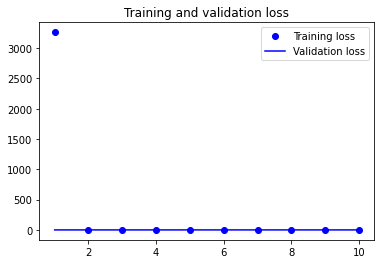

In [15]:
import matplotlib.pyplot as plt
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

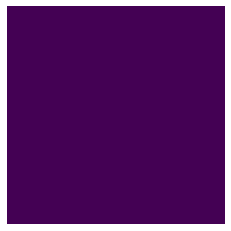

In [16]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("best_model.keras")

i = 9
test_image = images_test[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

## CAM